# Data Acquisition

In this notebook, we download and process the data so that in a next step we are able to work on it.
Processing in at this point includes:
- projection/clipping to equal AOI
- time matching
- handle no-data
- resolution equalization (could be moved to [02_TroMoM](02_TroMoM.ipynb)
- creation of reasonable file structure for processed data
- (format conversion)


In [9]:
import geopandas as gpd

from TroMoM.utils.visualization import plot_AOI

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- Define an area of interest (AOI) by specifying an input geoJSON/shapefile.
- Define a time interval of interest.

### Settings

In [13]:
AOI_file = "./misc/borneo.geojson" # alternatively coordinates: # Example over the state of Colorado: -109,37,-102,41
time = ["2023-01-01", "2023-04-30"]

smap_shortname = "SPL2SMAP_S"

visualize AOI:

kwargs: {'figsize': (12, 6)}


C:\Users\colin\OneDrive - TUM\Code\TroMoM\utils\visualization.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


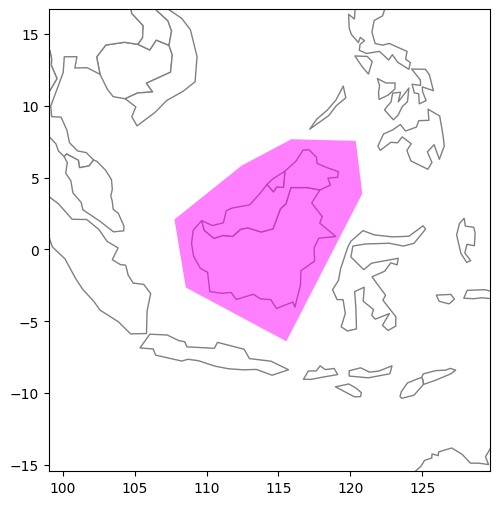

In [11]:
AOI = gpd.read_file(AOI_file)
f, ax = plot_AOI(AOI)

### SMAP
Download of soil moisture data

In [ ]:
### short names
"""

# usable for TroMoM

SPL2SMAP_S | SMAP/Sentinel-1 L2 Radiometer/Radar 30-Second Scene 3 km EASE-Grid Soil Moisture V003
- recent

SPL2SMP_E 005 | SMAP Enhanced L2 Radiometer Half-Orbit 9 km EASE-Grid Soil Moisture
- recent

SPL3SMP_E 004 | SMAP Enhanced L3 Radiometer Global and Polar Grid Daily 9 km EASE-Grid Soil Moisture
- 2015-03-31 - recent

SPL2SMP_NRT | Near Real-time SMAP L2 Radiometer Half-Orbit 36 km EASE-Grid Soil Moisture V107
- 2023-02-17 - recent





### all soil moisture

SPL2SMA | SMAP L2 Radar Half-Orbit 3 km EASE-Grid Soil Moisture V003
- only 2015
SPL2SMAP | SMAP L2 Radar/Radiometer Half-Orbit 9 km EASE-Grid Soil Moisture V003
- only 2015
SPL2SMAP_S | SMAP/Sentinel-1 L2 Radiometer/Radar 30-Second Scene 3 km EASE-Grid Soil Moisture V003
- recent



SPL2SMP 007 | SMAP L2 Radiometer Half-Orbit 36 km EASE-Grid Soil Moisture
- until 2021
SPL2SMP 008 |
- recent
SPL2SMP_E 004 | SMAP Enhanced L2 Radiometer Half-Orbit 9 km EASE-Grid Soil Moisture
- until 2021
SPL2SMP_E 005 | SMAP Enhanced L2 Radiometer Half-Orbit 9 km EASE-Grid Soil Moisture
- recent

SPL2SMP_NRT | Near Real-time SMAP L2 Radiometer Half-Orbit 36 km EASE-Grid Soil Moisture V107
- 2023-02-17 - recent


SPL3SMA | SMAP L3 Radar Global Daily 3 km EASE-Grid Soil Moisture V003
- only 2015
SPL3SMAP | SMAP L3 Radar/Radiometer Global Daily 9 km EASE-Grid Soil Moisture V003
- only 2015


SPL3SMP 007 | SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture
- 2015-03-31 - 2021-10-28
SPL3SMP 008 | SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture
- 2015-03-31 - recent

SPL3SMP_E 005 | SMAP Enhanced L3 Radiometer Global and Polar Grid Daily 9 km EASE-Grid Soil Moisture
- 2015-03-31 - 2021-10-28
SPL3SMP_E 004 | SMAP Enhanced L3 Radiometer Global and Polar Grid Daily 9 km EASE-Grid Soil Moisture
- 2015-03-31 - recent





### other

SPL3FTA | SMAP L3 Radar Northern Hemisphere Daily 3 km EASE-Grid Freeze/Thaw State V003
SPL3FTP | SMAP L3 Radiometer Global and Northern Hemisphere Daily 36 km EASE-Grid Freeze/Thaw State V003
SPL3FTP_E | SMAP Enhanced L3 Radiometer Global and Northern Hemisphere Daily 9 km EASE-Grid Freeze/Thaw State V003

SPL4CMDL | SMAP L4 Global Daily 9 km EASE-Grid Carbon Net Ecosystem Exchange V007
SPL4SMAU | SMAP L4 Global 3-hourly 9 km EASE-Grid Surface and Root Zone Soil Moisture Analysis Update V007
SPL4SMGP | SMAP L4 Global 3-hourly 9 km EASE-Grid Surface and Root Zone Soil Moisture Geophysical Data V007
SPL4SMLM | SMAP L4 Global 9 km EASE-Grid Surface and Root Zone Soil Moisture Land Model Constants V007





"""

In [ ]:
def download_smap(shortname, AOI, times, data_dir="data/smap", version=None): pass
def download_ndvi(AOI, time, data_dir="data/ndvi"): pass
def download_surface_temp(AOI, time, data_dir="data/smap"): pass
def download_population(AOI, time, data_dir="data/smap"): pass